4. Формирование выборки
5. Базовые модели прогнозирования
6. Модели машинного обучения
7. Обучение и оценка моделей

In [171]:
import pandas as pd
import numpy as np


### Классические модели временных рядов: ARIMA и SARIMA

В рамках анализа временных рядов традиционно применяются статистические модели ARIMA (Autoregressive Integrated Moving Average) и её расширение SARIMA (Seasonal ARIMA).  
ARIMA моделирует зависимости между прошлыми значениями ряда и ошибками прогноза, позволяя строить прогнозы и оценивать доверительные интервалы. SARIMA дополнительно учитывает сезонные компоненты, что делает её применимой для данных с регулярными колебаниями (например, недельными или годовыми циклами).

В данном проекте данные модели были рассмотрены как возможный инструмент прогнозирования. Однако для криптовалютного рынка характерны высокая волатильность и слабая выраженность сезонности, поэтому применение ARIMA и SARIMA не даёт значимого преимущества в точности прогноза.  
В связи с этим основной акцент в работе сделан на современных моделях машинного обучения и нейросетевых подходах (линейная регрессия, Random Forest, XGBoost, LSTM), которые лучше справляются с нелинейными зависимостями и динамическими особенностями цен криптовалют.

#### Сравнение подходов к прогнозированию

| Подход | Преимущества | Ограничения | Применимость к криптовалютам |
|--------|--------------|-------------|------------------------------|
| **ARIMA** | Простая реализация; понятные параметры (p,d,q); доверительные интервалы прогноза | Требует стационарности; плохо работает при высокой волатильности; не учитывает внешние факторы | Даёт базовый ориентир (benchmark), но слабо описывает резкие колебания |
| **SARIMA** | Учитывает сезонность; расширяет возможности ARIMA | Сложнее настройка; подходит только при выраженных сезонных паттернах | Сезонность у криптовалют выражена слабо → модель не даёт значимого улучшения |
| **ML (Linear Regression, Random Forest, XGBoost)** | Улавливают нелинейные зависимости; можно включать внешние признаки (Gold, SMA, Volume); выше точность прогноза | Требуют подготовки признаков (лаги, индикаторы); меньше интерпретируемости, чем ARIMA | Хорошо подходят для краткосрочного прогноза и анализа влияния факторов |
| **DL (LSTM)** | Учитывает долгосрочные зависимости; гибко адаптируется к сложным паттернам | Требует больших данных и ресурсов; «чёрный ящик» | Может уловить скрытые режимы рынка и улучшить качество прогноза |

---

### Линейная регрессия

**Линейная регрессия** — это базовый метод машинного обучения, который моделирует зависимость целевой переменной от набора факторов (признаков) с помощью линейной комбинации. Модель имеет вид:

$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n
$$

где $\hat{y}$ — прогнозируемое значение, $x_i$ — признаки, $\beta_i$ — коэффициенты модели.

**Для чего используется:**  
- даёт простой и интерпретируемый способ оценить, как признаки влияют на целевую переменную;  
- служит отправной точкой (benchmark) для сравнения с более сложными моделями.

**Применение в проекте:**  
В данном исследовании линейная регрессия используется для прогнозирования цены закрытия Bitcoin на следующий день. В качестве признаков применяются: лаги самой цены, скользящая средняя (SMA_200), цена золота (Gold), объём торгов (Volume) и индикатор волатильности (ATR_14). Такой набор позволяет проверить, насколько простая линейная комбинация технических индикаторов и макрофакторов может объяснить динамику курса криптовалюты.

**Метрики качества:**  
Для оценки точности прогноза используются стандартные метрики регрессии:  
- **MAE (Mean Absolute Error)** — средняя абсолютная ошибка;  
- **RMSE (Root Mean Squared Error)** — среднеквадратичная ошибка, чувствительна к выбросам;  
- **MAPE (Mean Absolute Percentage Error)** — средняя относительная ошибка в процентах.  

**Выводы по итогам применения:**  
- линейная регрессия покажет, в какой степени цена Bitcoin зависит от выбранных факторов в линейной форме;  
- коэффициенты модели позволят оценить направление и силу влияния признаков (например, рост золота → рост BTC);  
- результаты регрессии станут отправной точкой для сравнения с нелинейными моделями (Random Forest, XGBoost) и нейросетями (LSTM).  

In [176]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Загружаем датасет
df_input = pd.read_csv("final_merged_correllated.csv", parse_dates=["Date"]).sort_values("Date")
df_input = df_input.set_index("Date")

display(df_input)
df_input.info()

,Close,Volume,SMA_50,SMA_200,ATR_14,Gold
Date,,,,,,
2014-09-17,457.334015,21056800,457.334015,457.334015,15.752014,1234.400024
2014-09-18,424.440002,34483200,440.887009,440.887009,29.991013,1225.699951
2014-09-19,394.795990,37919700,425.523336,425.523336,34.428335,1215.300049
2014-09-22,402.152008,24127600,414.407837,414.407837,27.621496,1216.800049
2014-09-23,435.790985,45099500,417.462572,417.462572,30.155570,1221.000000
...,...,...,...,...,...,...
2025-08-25,110124.351562,85706860190,116508.301719,100854.757305,3395.174665,3373.800049
2025-08-26,111802.656250,69396320317,116578.357813,100931.125156,3506.690848,3388.600098
2025-08-27,111222.062500,62137056409,116623.793594,101004.823203,3326.571429,3404.600098


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2856 entries, 2014-09-17 to 2025-08-29
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    2856 non-null   float64
 1   Volume   2856 non-null   int64  
 2   SMA_50   2856 non-null   float64
 3   SMA_200  2856 non-null   float64
 4   ATR_14   2856 non-null   float64
 5   Gold     2754 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 156.2 KB


---
## Формирование выборки
---

In [179]:
# 1) копирование начального датасета (Date переносим из индекса в отдельный столбец)
df = df_input.copy().reset_index()

# 2) Признаки на момент t 
feature_cols = ["Close", "Gold", "SMA_200", "Volume", "ATR_14"]
X_all = df[feature_cols].copy()

# 3) Таргет = Close_{t+1}, а также даты прогноза (t+1)
y_all = df["Close"].shift(-1)                     # прогноз на 1 день вперёд
pred_dates = df["Date"] + pd.Timedelta(days=1)    # дата прогноза

# 4) Чистка пропусков
data = pd.concat([X_all, y_all.rename("y"), pred_dates.rename("PredDate")], axis=1).dropna()
X, y = data[feature_cols], data["y"]
pred_dates_clean = data["PredDate"]

# 5) Сплит по времени (train = всё до последних 180 дней, test = последние 180)
TEST_DAYS = 180
split = len(X) - TEST_DAYS
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
dates_test = pred_dates_clean.iloc[split:]

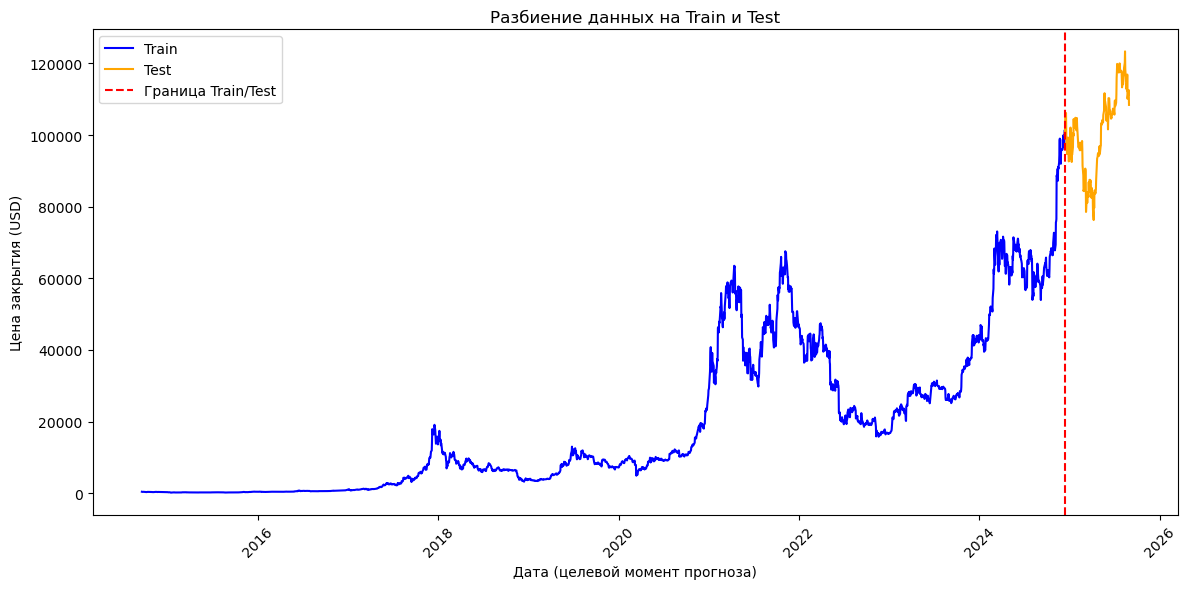

In [181]:
# ===== Визуализация Train/Test разбиения =====

# даты, выровненные с y (после dropna)
dates_all = pred_dates_clean  # из твоего data[...] выше

# train/test разбиение по тем же индексам
plt.figure(figsize=(12,6))
plt.plot(dates_all.iloc[:split], y.iloc[:split], label="Train", color="blue")
plt.plot(dates_all.iloc[split:], y.iloc[split:], label="Test", color="orange")

# линия границы
plt.axvline(dates_all.iloc[split], color="red", linestyle="--", label="Граница Train/Test")

plt.title("Разбиение данных на Train и Test")
plt.xlabel("Дата (целевой момент прогноза)")
plt.ylabel("Цена закрытия (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Linear Regression | RMSE=2,462.33  MAE=1,876.08  MAPE=1.91%

Коэффициенты модели (по модулю):
 Close      21322.497055
Gold         113.492335
Volume        60.900111
SMA_200      -41.222061
ATR_14         3.323172
dtype: float64


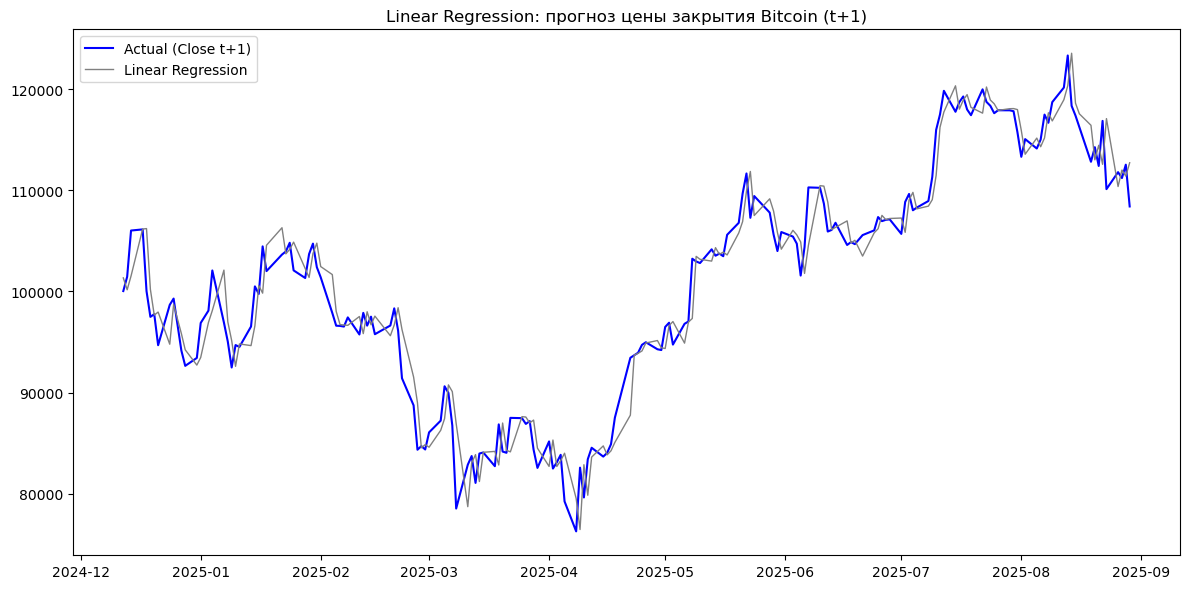

In [183]:
# === Линейная регрессия для прогноза цены BTC === 

# пункты 1-5 - в разделе формирование выборки

# 6) Модель: стандартизация + линейная регрессия
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])
pipe.fit(X_train, y_train)

# 7) Прогноз и метрики
y_pred_ln = pipe.predict(X_test)
rmse_ln = np.sqrt(mean_squared_error(y_test, y_pred_ln))
mae_ln  = mean_absolute_error(y_test, y_pred_ln)
mape_ln = (np.abs((y_test - y_pred_ln) / y_test)).mean() * 100

print(f"Linear Regression | RMSE={rmse_ln:,.2f}  MAE={mae_ln:,.2f}  MAPE={mape_ln:,.2f}%")

# 8) Коэффициенты (вклад признаков)
coef_ln = pd.Series(pipe.named_steps["linreg"].coef_, index=feature_cols).sort_values(key=np.abs, ascending=False)
print("\nКоэффициенты модели (по модулю):\n", coef_ln)

# 9) Визуализация: факт vs прогноз (для t+1)
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test.values, label="Actual (Close t+1)", color="blue")
plt.plot(dates_test, y_pred_ln, label="Linear Regression", linewidth=1, color="grey")
plt.title("Linear Regression: прогноз цены закрытия Bitcoin (t+1)")
plt.legend()
plt.tight_layout()
plt.show()

**Анализ полученных результатов (модель Линейная регрессия):**<br>
Применение линейной регрессии показало высокое качество прогноза: <br>
средняя относительная ошибка составила 1.91% (MAPE), средняя абсолютная ошибка — \\$1 876.08 (MAE), 
а среднеквадратичная ошибка — \\$2 462.33 (RMSE). Это означает, что модель в среднем ошибалась менее чем на 2% 
при прогнозе цены закрытия Bitcoin на следующий день.  

Анализ коэффициентов показал, что ключевым фактором является текущая цена закрытия Bitcoin, 
которая вносит основной вклад в прогноз. Дополнительные признаки — цена золота, объём торгов, SMA_200 и ATR_14 — 
оказывают сравнительно небольшое влияние.  

Таким образом, линейная регрессия демонстрирует высокую точность и хорошую интерпретируемость, 
что делает её надёжной базовой моделью для последующего сравнения с более сложными методами машинного обучения 
и нейросетевыми подходами.

Пример прогноза цены закрытия Bitcoin модели Линейная регрессия (последние 10 строк):


,Date,Actual_Close_t+1,Pred_Close_t+1,Error
170,2025-08-16,116252.312500,117572.323706,-1320.011206
171,2025-08-19,112831.179688,116439.842709,-3608.663021
172,2025-08-20,114274.742188,113022.258867,1252.483321
173,2025-08-21,112419.031250,114459.110971,-2040.079721
174,2025-08-22,116874.085938,112578.933996,4295.151942
175,2025-08-23,110124.351562,117099.947275,-6975.595712
176,2025-08-26,111802.656250,110382.510231,1420.146019
177,2025-08-27,111222.062500,112013.505815,-791.443315
178,2025-08-28,112544.804688,111418.429202,1126.375485
179,2025-08-29,108410.835938,112734.123263,-4323.287325


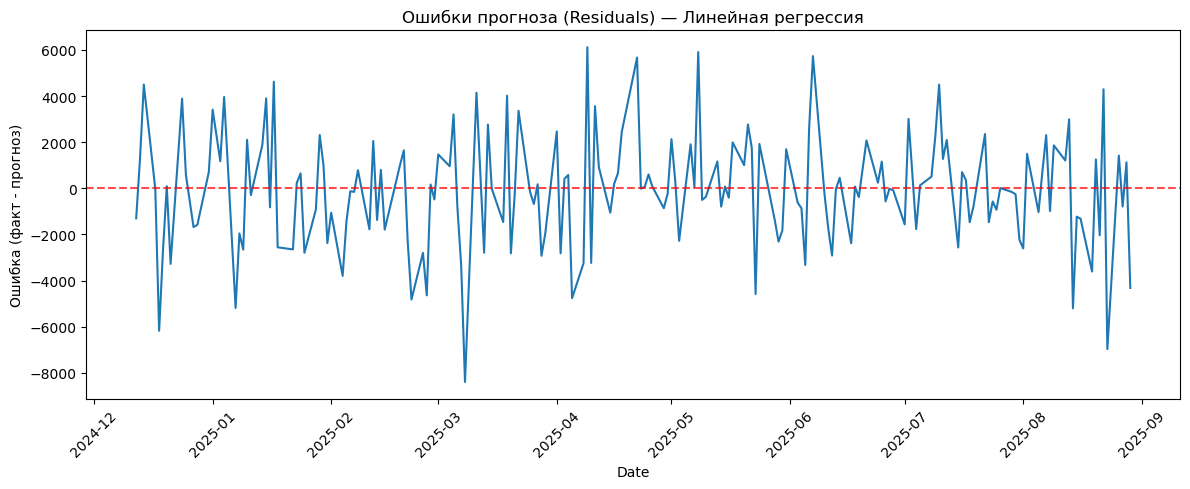

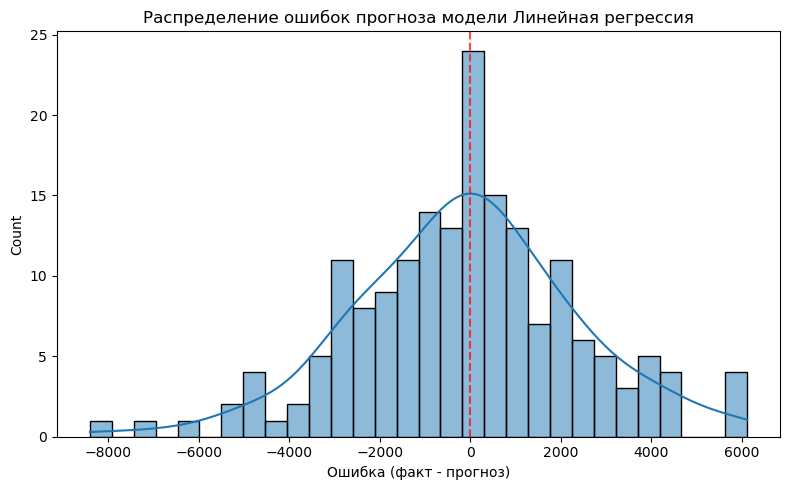

In [186]:
# === Дополнение: анализ ошибок прогноза Линейной регрессии ===

import seaborn as sns

# 1) Таблица с первыми 10 строками прогноза
results_ln = pd.DataFrame({
    "Date": dates_test,
    "Actual_Close_t+1": y_test.values,
    "Pred_Close_t+1": y_pred_ln,
    "Error": y_test.values - y_pred_ln
}).reset_index(drop=True)             # сбрасываем индекс, Date остаётся столбцом

print("Пример прогноза цены закрытия Bitcoin модели Линейная регрессия (последние 10 строк):")
display(results_ln.tail(10))

# 2) График ошибок (residuals)
plt.figure(figsize=(12,5))
sns.lineplot(x=results_ln["Date"], y=results_ln["Error"])
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.title("Ошибки прогноза (Residuals) — Линейная регрессия")
plt.ylabel("Ошибка (факт - прогноз)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Гистограмма ошибок
plt.figure(figsize=(8,5))
sns.histplot(results_ln["Error"], bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--", alpha=0.7)
plt.title("Распределение ошибок прогноза модели Линейная регрессия")
plt.xlabel("Ошибка (факт - прогноз)")
plt.tight_layout()
plt.show()

---
---

### Random Forest

**Random Forest** — это ансамблевый метод машинного обучения, основанный на построении множества решающих деревьев.  
Каждое дерево обучается на случайной подвыборке данных и подмножестве признаков, а итоговый прогноз формируется как усреднение прогнозов всех деревьев (для задачи регрессии).  

**Преимущества метода:**
- способен улавливать **нелинейные зависимости** между признаками и целевой переменной;  
- устойчив к выбросам и шуму в данных;  
- не требует строгой подготовки данных (масштабирования, приведения к стационарности).  

**Применение в проекте:**  
В рамках данного исследования Random Forest используется для прогнозирования цены закрытия Bitcoin на следующий день.  
В качестве признаков применяются лаги самой цены (`Close`), технические индикаторы (`SMA_200`, `ATR_14`), объём торгов (`Volume`) и макроэкономический фактор — цена золота (`Gold`).  
Это позволяет проверить, насколько нелинейный ансамблевый метод может улучшить результаты по сравнению с линейной регрессией.  

**Метрики качества:**  
Точность модели оценивается с помощью:  
- **MAE (Mean Absolute Error)** — средняя абсолютная ошибка;  
- **RMSE (Root Mean Squared Error)** — среднеквадратичная ошибка;  
- **MAPE (Mean Absolute Percentage Error)** — средняя относительная ошибка в процентах.  

**Ожидаемые выводы:**  
- Random Forest должен показать более низкие ошибки прогноза по сравнению с линейной регрессией за счёт учёта нелинейностей.  
- Важность признаков, вычисленная моделью, позволит выявить, какие факторы оказывают наибольшее влияние на цену Bitcoin.  
- Итоги применения модели помогут оценить, насколько добавление ансамблевых методов повышает точность прогнозирования криптовалютных временных рядов.

In [190]:
df_input

,Close,Volume,SMA_50,SMA_200,ATR_14,Gold
Date,,,,,,
2014-09-17,457.334015,21056800,457.334015,457.334015,15.752014,1234.400024
2014-09-18,424.440002,34483200,440.887009,440.887009,29.991013,1225.699951
2014-09-19,394.795990,37919700,425.523336,425.523336,34.428335,1215.300049
2014-09-22,402.152008,24127600,414.407837,414.407837,27.621496,1216.800049
2014-09-23,435.790985,45099500,417.462572,417.462572,30.155570,1221.000000
...,...,...,...,...,...,...
2025-08-25,110124.351562,85706860190,116508.301719,100854.757305,3395.174665,3373.800049
2025-08-26,111802.656250,69396320317,116578.357813,100931.125156,3506.690848,3388.600098
2025-08-27,111222.062500,62137056409,116623.793594,101004.823203,3326.571429,3404.600098


Random Forest | RMSE=10,926.94  MAE=9,051.13  MAPE=8.78%

Важность признаков:
 Close      0.996413
SMA_200    0.002148
Gold       0.000500
ATR_14     0.000480
Volume     0.000459
dtype: float64


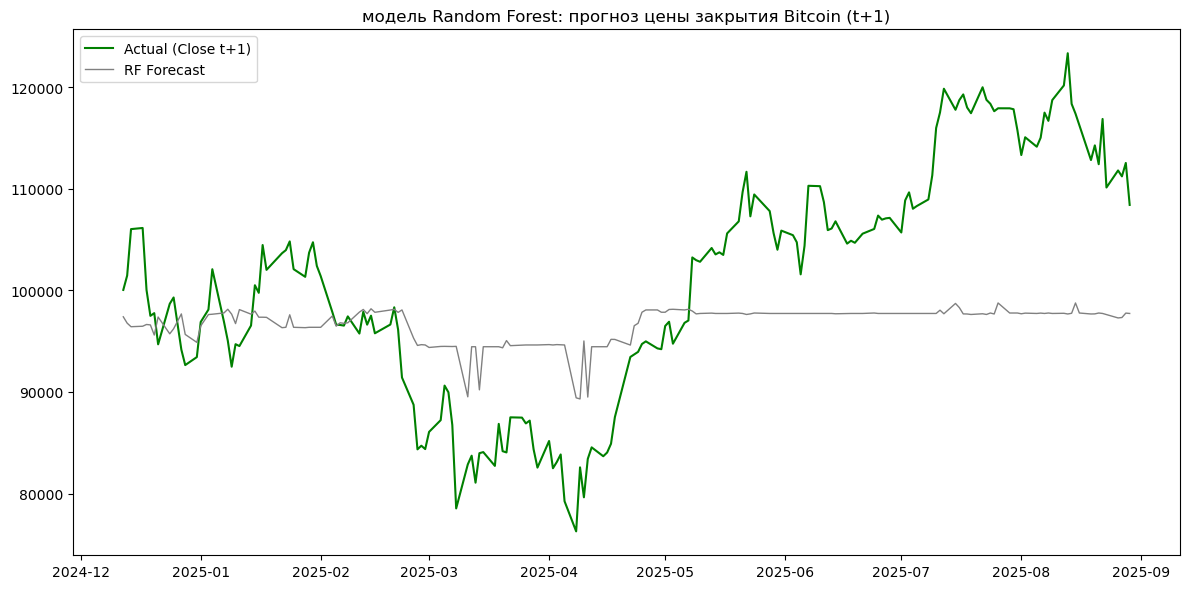

In [192]:
# === Random Forest для прогноза цены BTC ===

from sklearn.ensemble import RandomForestRegressor

# пункты 1-5 - в разделе формирование выборки

# 6) Обучение Random Forest (простые настройки)
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 7) Прогноз и метрики
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
mape_rf = (np.abs((y_test - y_pred_rf) / y_test)).mean() * 100

print(f"Random Forest | RMSE={rmse_rf:,.2f}  MAE={mae_rf:,.2f}  MAPE={mape_rf:,.2f}%")

# 8) Важность признаков
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nВажность признаков:\n", importances)

# 9) График: факт vs прогноз (t+1)
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test.values, label="Actual (Close t+1)", color="green")
plt.plot(dates_test, y_pred_rf, label="RF Forecast", linewidth=1, color="grey")
plt.title("модель Random Forest: прогноз цены закрытия Bitcoin (t+1)")
plt.legend()
plt.tight_layout()
plt.show()

**Анализ полученных результатов (модель Random Forest):**<br>
Применение модели Random Forest без лагов показало среднюю относительную ошибку 8.78% (MAPE), 
что значительно выше, чем у линейной регрессии. Средняя абсолютная ошибка составила \\$9 051.13, 
а среднеквадратичная ошибка — \\$10 926.94.  

Анализ важности признаков показал, что практически вся предсказательная сила модели приходится 
на текущую цену закрытия Bitcoin, в то время как остальные факторы (SMA_200, цена золота, объём торгов, ATR_14) 
оказались малозначимыми.  

Таким образом, в условиях прогноза на один день вперёд Random Forest не смог показать преимущества 
и уступил по точности более простой линейной модели.

Пример прогноза цены закрытия Bitcoin модели Random Forest (последние 10 строк):


,Date,Actual_Close_t+1,Pred_Close_t+1,Error
170,2025-08-16,116252.312500,97769.253464,18483.059036
171,2025-08-19,112831.179688,97674.128281,15157.051406
172,2025-08-20,114274.742188,97683.329661,16591.412526
173,2025-08-21,112419.031250,97769.253464,14649.777786
174,2025-08-22,116874.085938,97725.463984,19148.621953
175,2025-08-23,110124.351562,97617.753854,12506.597708
176,2025-08-26,111802.656250,97284.883802,14517.772448
177,2025-08-27,111222.062500,97326.731068,13895.331432
178,2025-08-28,112544.804688,97760.758958,14784.045729
179,2025-08-29,108410.835938,97725.463984,10685.371953


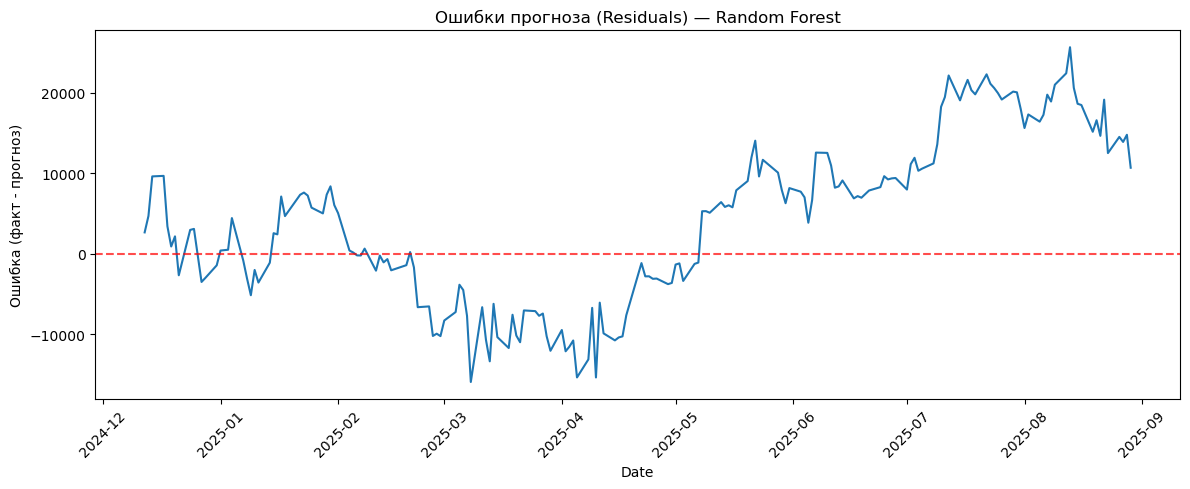

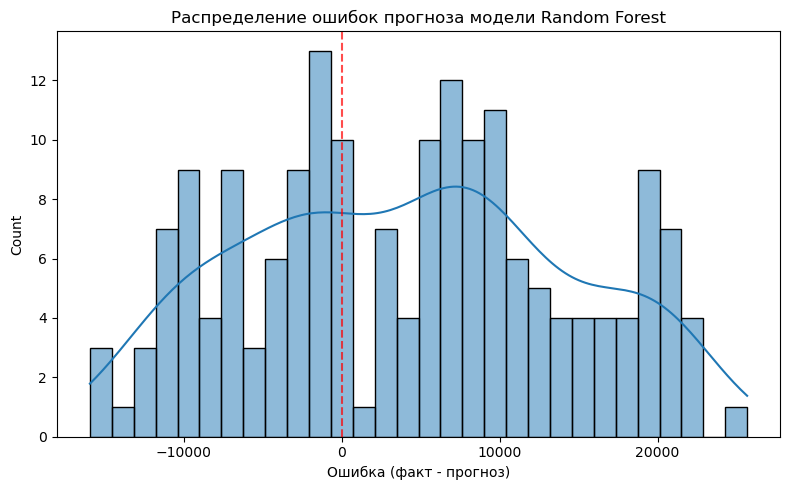

In [195]:
# === Дополнение: анализ ошибок прогноза модели Random Forest ===

# 1) Таблица с первыми 10 строками прогноза
results_rf = pd.DataFrame({
    "Date": dates_test,
    "Actual_Close_t+1": y_test.values,
    "Pred_Close_t+1": y_pred_rf,
    "Error": y_test.values - y_pred_rf
}).reset_index(drop=True)             # сбрасываем индекс, Date остаётся столбцом

print("Пример прогноза цены закрытия Bitcoin модели Random Forest (последние 10 строк):")
display(results_rf.tail(10))

# 2) График ошибок (residuals)
plt.figure(figsize=(12,5))
sns.lineplot(x=results_rf["Date"], y=results_rf["Error"])
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.title("Ошибки прогноза (Residuals) — Random Forest")
plt.ylabel("Ошибка (факт - прогноз)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Гистограмма ошибок
plt.figure(figsize=(8,5))
sns.histplot(results_rf["Error"], bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--", alpha=0.7)
plt.title("Распределение ошибок прогноза модели Random Forest")
plt.xlabel("Ошибка (факт - прогноз)")
plt.tight_layout()


---
---

### XGBoost

**XGBoost (Extreme Gradient Boosting)** — это одна из самых популярных реализаций градиентного бустинга, основанного на ансамбле деревьев решений.  
Модель строит последовательность деревьев, где каждое следующее дерево исправляет ошибки предыдущих. В результате формируется сильный предсказатель, который хорошо улавливает сложные зависимости в данных.

**Преимущества XGBoost:**
- высокая точность за счёт учёта нелинейных связей и взаимодействий признаков;  
- встроенная регуляризация, которая предотвращает переобучение;  
- возможность оценивать важность признаков (Feature Importance, SHAP-анализ).  

**Применение в проекте:**  
XGBoost используется для прогнозирования цены закрытия Bitcoin на следующий день.  
Признаки: лаги цены (`Close`), скользящая средняя (`SMA_200`), объём торгов (`Volume`), волатильность (`ATR_14`) и цена золота (`Gold`).  
Это позволяет оценить, насколько мощный бустинговый алгоритм может улучшить точность прогноза по сравнению с линейной регрессией и Random Forest.

**Метрики качества:**  
- RMSE (Root Mean Squared Error)  
- MAE (Mean Absolute Error)  
- MAPE (Mean Absolute Percentage Error)

**Ожидаемые выводы:**  
XGBoost должен показывать более низкие ошибки, чем Random Forest, и лучше учитывать нелинейные зависимости.  
Даже если точность окажется сравнимой с линейной регрессией, XGBoost ценен тем, что позволяет провести интерпретацию признаков (например, через SHAP-анализ) и выявить скрытые закономерности.

In [199]:
df_input

,Close,Volume,SMA_50,SMA_200,ATR_14,Gold
Date,,,,,,
2014-09-17,457.334015,21056800,457.334015,457.334015,15.752014,1234.400024
2014-09-18,424.440002,34483200,440.887009,440.887009,29.991013,1225.699951
2014-09-19,394.795990,37919700,425.523336,425.523336,34.428335,1215.300049
2014-09-22,402.152008,24127600,414.407837,414.407837,27.621496,1216.800049
2014-09-23,435.790985,45099500,417.462572,417.462572,30.155570,1221.000000
...,...,...,...,...,...,...
2025-08-25,110124.351562,85706860190,116508.301719,100854.757305,3395.174665,3373.800049
2025-08-26,111802.656250,69396320317,116578.357813,100931.125156,3506.690848,3388.600098
2025-08-27,111222.062500,62137056409,116623.793594,101004.823203,3326.571429,3404.600098


In [201]:
# !pip install xgboost

XGBoost (без лагов) | RMSE=11,033.38  MAE=8,913.72  MAPE=8.51%
Best iteration: 421

Важность признаков:
 Close      0.777885
ATR_14     0.109378
SMA_200    0.082857
Gold       0.028716
Volume     0.001165
dtype: float32


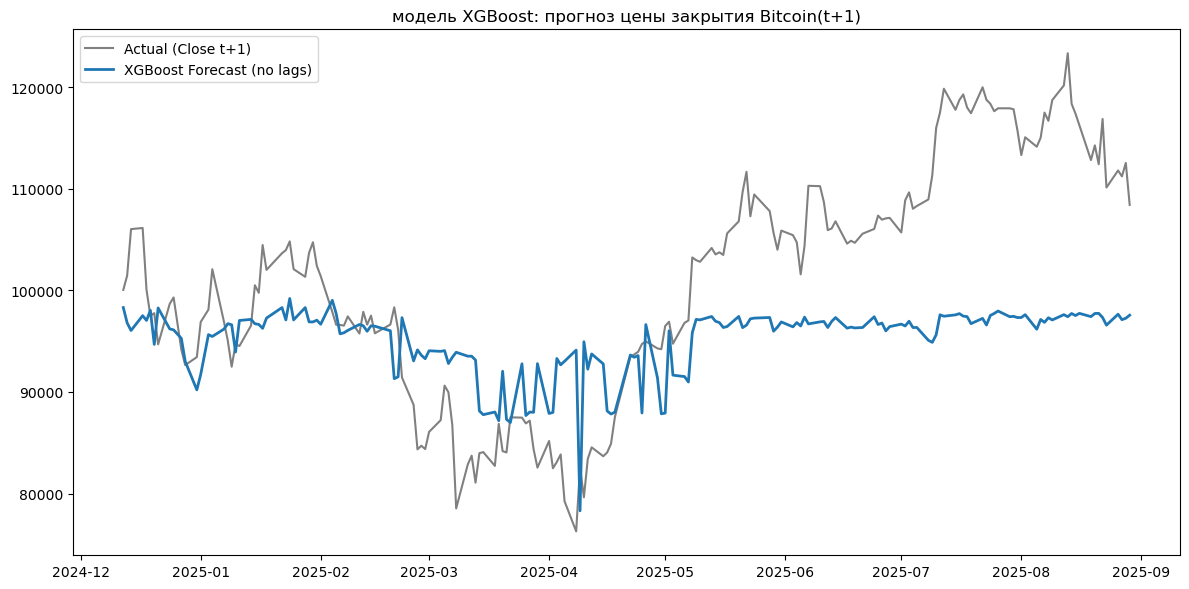

In [203]:
# === XGBoost для прогноза цены BTC (t+1) ===

from xgboost import XGBRegressor

# пункты 1-5 - в разделе формирование выборки

# 6) Обучение XGBoost (базовые параметры + early stopping)
xgb = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    objective="reg:squarederror",
    tree_method="hist",
    early_stopping_rounds=100,
    eval_metric="rmse"
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# 7) Прогноз и метрики
y_pred_xg = xgb.predict(X_test)
rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred_xg))
mae_xg  = mean_absolute_error(y_test, y_pred_xg)
mape_xg = (np.abs((y_test - y_pred_xg) / y_test)).mean() * 100

print(f"XGBoost (без лагов) | RMSE={rmse_xg:,.2f}  MAE={mae_xg:,.2f}  MAPE={mape_xg:,.2f}%")
print("Best iteration:", getattr(xgb, "best_iteration", None))

# 8) Важность признаков
importances = pd.Series(xgb.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nВажность признаков:\n", importances)

# 9) График: факт vs прогноз
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test.values, label="Actual (Close t+1)", color="gray")
plt.plot(dates_test, y_pred_xg, label="XGBoost Forecast (no lags)", linewidth=2)
plt.title("модель XGBoost: прогноз цены закрытия Bitcoin(t+1)")
plt.legend()
plt.tight_layout()
plt.show()


**Анализ полученных результатов (модель XGBoost):**<br>
Применение XGBoost без лагов показало среднюю относительную ошибку прогноза (MAPE) 8.51%, 
при средней абсолютной ошибке \\$8 913.72 и \\$RMSE 11 033.38. 
Качество прогноза оказалось сопоставимым с результатами Random Forest и хуже, чем у линейной регрессии.  

Анализ важности признаков показал, что ключевым фактором прогноза остаётся текущая цена закрытия Bitcoin (77.8%). 
Некоторое влияние оказывают долгосрочный тренд (SMA_200, 8.3%) и показатель волатильности (ATR_14, 10.9%). 
Золото и объём торгов имеют минимальное значение.  

Таким образом, XGBoost, несмотря на более сложный алгоритм, не смог превзойти по точности простую линейную модель, 
но дал более разнообразную картину распределения значимости факторов.

Пример прогноза цены закрытия Bitcoin модели XGBoost (последние 10 строк):


,Date,Actual_Close_t+1,Pred_Close_t+1,Error
170,2025-08-16,116252.312500,97734.539062,18517.773438
171,2025-08-19,112831.179688,97414.335938,15416.843750
172,2025-08-20,114274.742188,97726.281250,16548.460938
173,2025-08-21,112419.031250,97734.539062,14684.492188
174,2025-08-22,116874.085938,97326.453125,19547.632812
175,2025-08-23,110124.351562,96576.835938,13547.515625
176,2025-08-26,111802.656250,97648.234375,14154.421875
177,2025-08-27,111222.062500,97112.960938,14109.101562
178,2025-08-28,112544.804688,97253.421875,15291.382812
179,2025-08-29,108410.835938,97556.898438,10853.937500


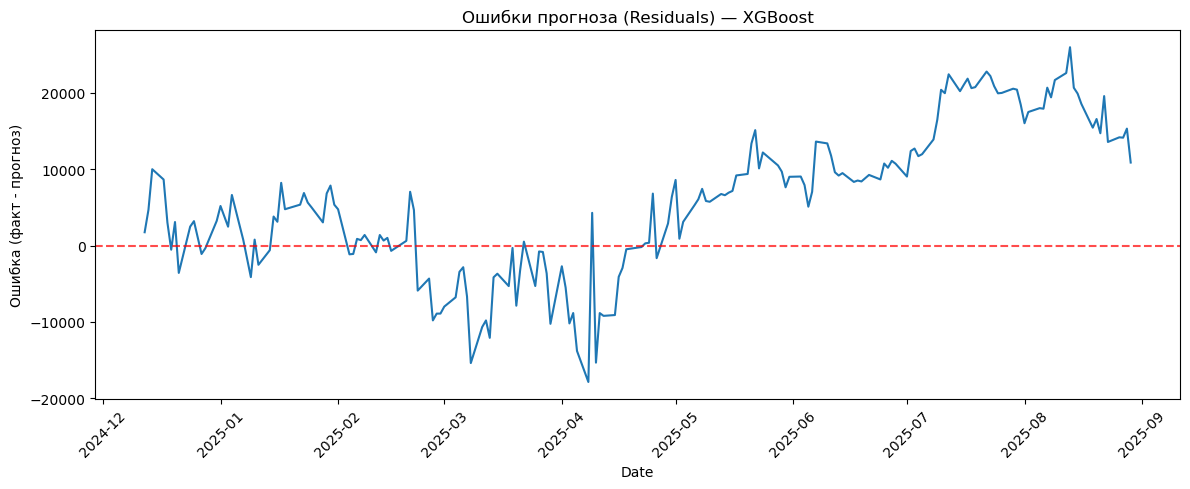

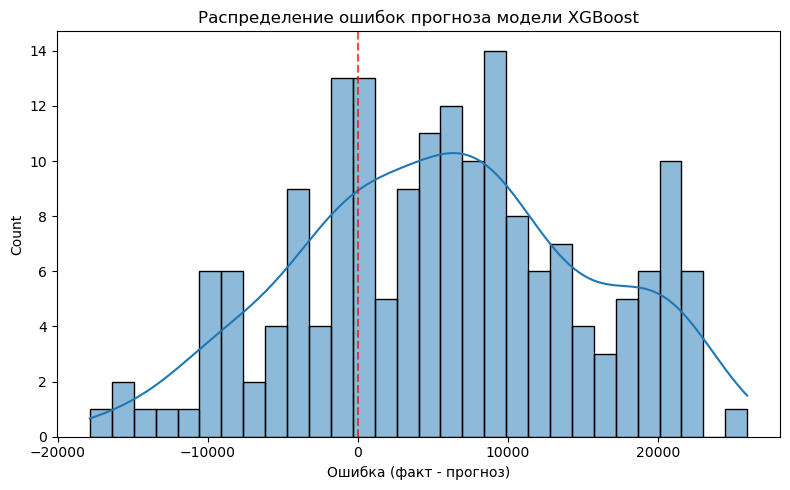

In [206]:
# === Дополнение: анализ ошибок прогноза модели XGBoost ===

# 1) Таблица с первыми 10 строками прогноза
results_xg = pd.DataFrame({
    "Date": dates_test,
    "Actual_Close_t+1": y_test.values,
    "Pred_Close_t+1": y_pred_xg,
    "Error": y_test.values - y_pred_xg
}).reset_index(drop=True)                  # сбрасываем индекс, Date остаётся столбцом

print("Пример прогноза цены закрытия Bitcoin модели XGBoost (последние 10 строк):")
display(results_xg.tail(10))

# 2) График ошибок (residuals)
plt.figure(figsize=(12,5))
sns.lineplot(x=results_xg["Date"], y=results_xg["Error"])
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.title("Ошибки прогноза (Residuals) — XGBoost")
plt.ylabel("Ошибка (факт - прогноз)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Гистограмма ошибок
plt.figure(figsize=(8,5))
sns.histplot(results_xg["Error"], bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--", alpha=0.7)
plt.title("Распределение ошибок прогноза модели XGBoost")
plt.xlabel("Ошибка (факт - прогноз)")
plt.tight_layout()

---
---

### LSTM (Long Short-Term Memory)

**LSTM (Long Short-Term Memory)** — это разновидность рекуррентных нейронных сетей (RNN), специально разработанная для работы с последовательными данными и временными рядами.

Особенности LSTM:
* способна «запоминать» информацию на длинных интервалах времени, что решает проблему затухающего/взрывающегося градиента в обычных RNN;
* хорошо подходит для прогнозирования временных рядов, особенно при наличии нелинейных зависимостей;
* используется в финансах, экономике и анализе криптовалют для предсказания цен.

В данном проекте LSTM позволит проверить, может ли нейросеть лучше уловить скрытые закономерности в динамике Bitcoin по сравнению с классическими моделями (Random Forest, XGBoost, линейная регрессия).

Метрики качества будут те же: RMSE, MAE, MAPE, что позволит сравнить нейросеть с остальными моделями.

План реализации LSTM
1. Подготовить данные:
* использовать только ряд Close (и, при желании, несколько признаков — Gold, SMA, Volume, ATR).
* нормализовать данные (нейросетям проще учиться на масштабированных значениях).
* сформировать обучающие последовательности (например, окно в 30 дней → прогноз на день вперёд).
2. Разделить на train/test (как у других моделей: последние 180 дней — тест).
3. Построить модель LSTM (Keras / TensorFlow):
* вход: окно цен/признаков,
* 1–2 слоя LSTM,
* выход: прогноз Close_t+1.
4. Обучить модель на train, протестировать на test.
5. Сравнить метрики (RMSE, MAE, MAPE) с другими моделями.



In [210]:
# !pip install tensorflow

При конфликте версий TensorFlow ↔︎ protobuf:
а. Вариант A (наиболее надёжно): зафиксировать protobuf 3.20.x
!pip install -U "protobuf==3.20.*"

б. Вариант B: обновить TensorFlow до совместимой версии
(если у тебя обычный CPU/Windows/Linux)
pip install -U "tensorflow>=2.15"

macOS (Apple Silicon):
pip install -U "tensorflow-macos>=2.13"
pip install -U tensorflow-metal

После установки обязательно: Restart kernel (Перезапустить ядро), затем:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [213]:
# !pip install -U "protobuf==3.20.*"

In [215]:
# !pip install -U "tensorflow-macos>=2.13"
# !pip install -U tensorflow-metal

In [217]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Модель вернула веса с эпохи 71, где была наименьшая ошибка валидации.


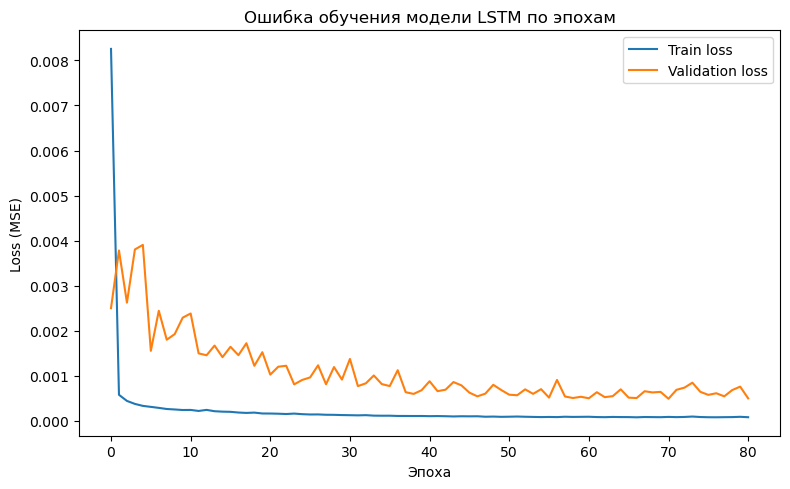

модель LSTM | RMSE=3,480.57  MAE=2,905.20  MAPE=2.85%


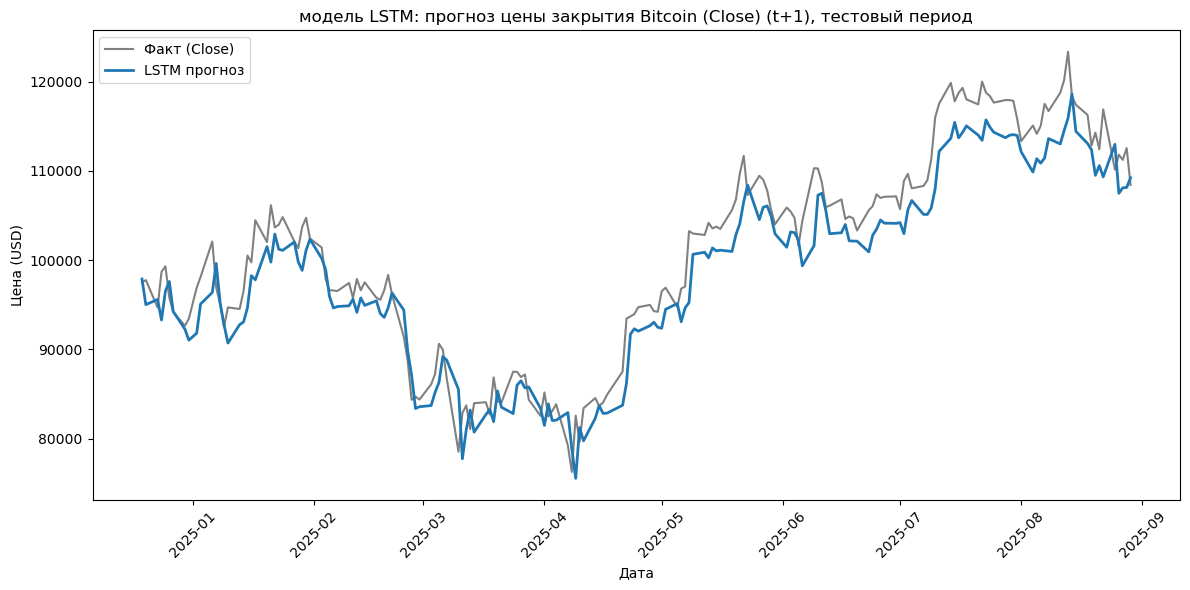

In [221]:
# === LSTM-прогноз Close на один день вперёд === (окно 30дней)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.callbacks import EarlyStopping

# 1) Настройки (можешь менять только это)
TEST_DAYS = 180       # сколько последних дней оставляем на проверку
WINDOW = 30           # сколько прошлых дней смотрим, чтобы предсказать следующий

# 2) Загружаем данные и берём только Date и Close
df = pd.read_csv("final_merged_correllated.csv", parse_dates=["Date"]).sort_values("Date")
dates = df["Date"].values
values = df["Close"].astype(float).values.reshape(-1, 1)

# 3) Масштабирование: обучаем на train-части, применяем ко всему
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values[:-TEST_DAYS])                       # обучаем на train
values_scaled = scaler.transform(values)

# 4) Делаем «окна» длиной 30(WINDOW): из последних 30(WINDOW) дней -> прогноз следующего дня
X, y = [], []
for i in range(WINDOW, len(values_scaled)):
    X.append(values_scaled[i-WINDOW:i, 0])  # 30(WINDOW) последних значений
    y.append(values_scaled[i, 0])           # следующее значение (на день вперёд)
X = np.array(X).reshape(-1, WINDOW, 1)
y = np.array(y)

# Даты для целевых значений (начинаются с позиции 30(WINDOW))
dates_y = dates[WINDOW:]

# 5) Делим на train/test по последним 180 точкам
split = len(y) - TEST_DAYS
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_test = dates_y[split:]  # даты для тестовых прогнозов

# 6) Строим модель LSTM
model = Sequential([
    LSTM(32, input_shape=(WINDOW, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

# 7) Обучаем 
# --- создаем callback для EarlyStopping
es = EarlyStopping(
    monitor="val_loss",          # следим за ошибкой на валидации
    patience=10,                 # ждём 10 эпох без улучшений
    restore_best_weights=True    # вернём веса с наилучшей эпохи
)

history = model.fit(
    X_train, y_train, 
    epochs=100,                   # можем ставить больше эпох (ранее стояло 40)
    batch_size=32, 
    validation_split=0.1,
    callbacks=[es],
    verbose=0)

best_epoch = es.stopped_epoch - es.patience + 1
print(f"Модель вернула веса с эпохи {best_epoch}, где была наименьшая ошибка валидации.")

# === График изменения ошибки по эпохам ===
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train loss")              # ошибка на train
plt.plot(history.history["val_loss"], label="Validation loss")     # ошибка на валидации
plt.title("Ошибка обучения модели LSTM по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.tight_layout()
plt.show()

# 8) Прогноз на тесте и обратное масштабирование
y_pred_scaled = model.predict(X_test, verbose=0).reshape(-1, 1)
y_test_scaled = y_test.reshape(-1, 1)

y_pred_lstm = scaler.inverse_transform(y_pred_scaled).ravel()
y_test_inv = scaler.inverse_transform(y_test_scaled).ravel()

# 9) Метрики
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm))
mae_lstm  = mean_absolute_error(y_test_inv, y_pred_lstm)
mape_lstm = (np.abs((y_test_inv - y_pred_lstm) / y_test_inv)).mean() * 100
print(f"модель LSTM | RMSE={rmse_lstm:,.2f}  MAE={mae_lstm:,.2f}  MAPE={mape_lstm:,.2f}%")

# 10) График: факт vs прогноз (тест)
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test_inv, label="Факт (Close)", color="gray")
plt.plot(dates_test, y_pred_lstm, label="LSTM прогноз", linewidth=2)
plt.title("модель LSTM: прогноз цены закрытия Bitcoin (Close) (t+1), тестовый период")
plt.xlabel("Дата"); plt.ylabel("Цена (USD)")
plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
plt.show()

**Анализ полученных результатов (модель LSTM):**<br>
Нейросеть LSTM показывает результаты, сопоставимые с линейной регрессией и лучше, чем у моделей Random Forest и XGBoost. Благодаря использованию временного окна в 30 дней модель способна улавливать долгосрочные зависимости в динамике временного ряда и демонстрирует низкие ошибки прогноза (MAPE < 3%). Это подтверждает, что LSTM может быть использована как надёжный инструмент для прикладного прогнозирования цены криптовалюты.

Пример прогноза цены закрытия Bitcoin модели LSTM (первые 10 строк):


,Date,Actual_Close,Pred_Close,Error
0,2024-12-19,97490.953125,98589.960938,-1099.007812
1,2024-12-20,97755.929688,95713.273438,2042.656250
2,2024-12-23,94686.242188,96361.875000,-1675.632812
3,2024-12-24,98676.093750,93546.671875,5129.421875
4,2024-12-25,99299.195312,97307.398438,1991.796875
5,2024-12-26,95795.515625,98270.882812,-2475.367188
6,2024-12-27,94164.859375,94473.718750,-308.859375
7,2024-12-30,92643.210938,92568.804688,74.406250
8,2024-12-31,93429.203125,91281.601562,2147.601562
9,2025-01-02,96886.875000,92180.945312,4705.929688


Пример прогноз цены закрытия Bitcoin модели LSTM (последние 10 строк):


,Date,Actual_Close,Pred_Close,Error
170,2025-08-18,116252.312500,113785.726562,2466.585938
171,2025-08-19,112831.179688,112966.218750,-135.039062
172,2025-08-20,114274.742188,109672.625000,4602.117188
173,2025-08-21,112419.031250,111031.906250,1387.125000
174,2025-08-22,116874.085937,109486.320312,7387.765625
175,2025-08-25,110124.351563,113662.554688,-3538.203125
176,2025-08-26,111802.656250,107292.617188,4510.039062
177,2025-08-27,111222.062500,108438.148438,2783.914062
178,2025-08-28,112544.804688,108405.179688,4139.625000
179,2025-08-29,108410.835938,109613.632812,-1202.796875


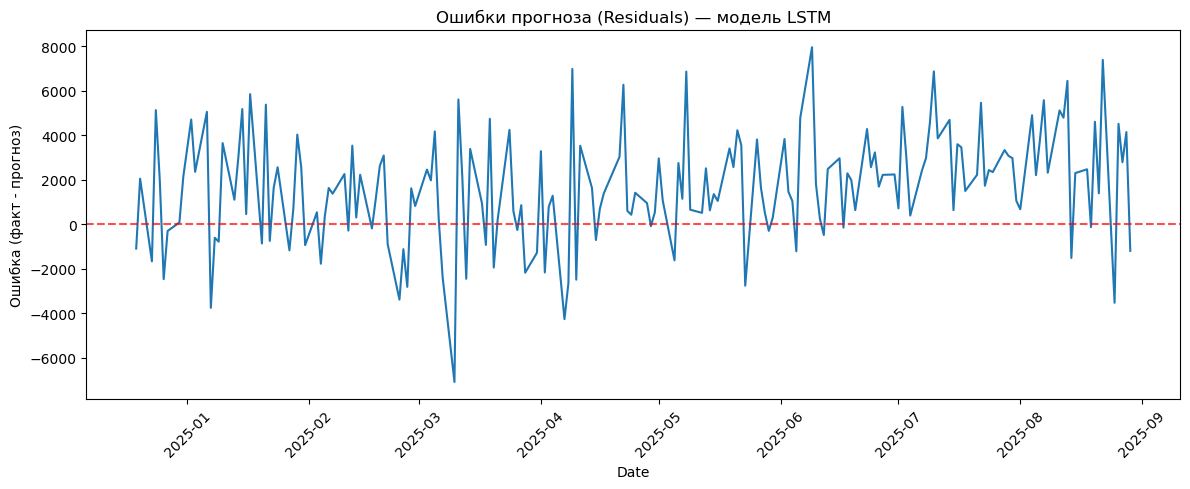

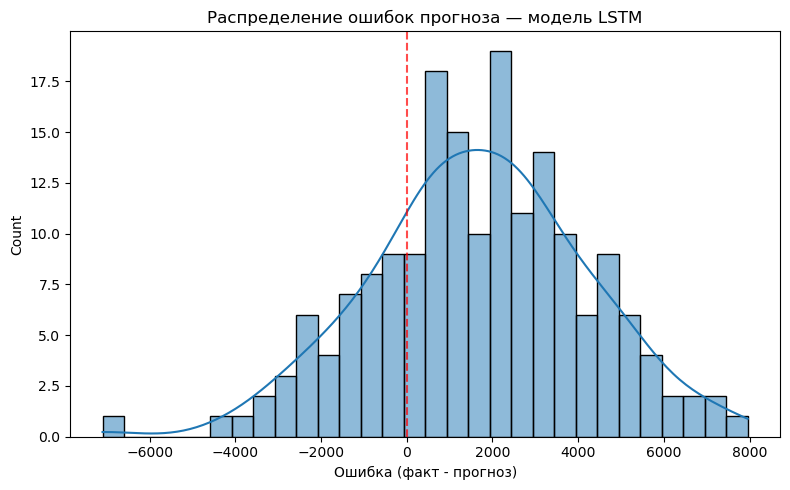

In [224]:
# === Дополнение: анализ ошибок прогноза модели LSTM ===
import seaborn as sns

# 1) Таблица с первыми/последними строками прогноза
results_lstm = pd.DataFrame({
    "Date": dates_test,
    "Actual_Close": y_test_inv,
    "Pred_Close": y_pred,
    "Error": y_test_inv - y_pred
}).reset_index(drop=True)

print("Пример прогноза цены закрытия Bitcoin модели LSTM (первые 10 строк):")
display(results_lstm.head(10))

print("Пример прогноз цены закрытия Bitcoin модели LSTM (последние 10 строк):")
display(results_lstm.tail(10))

# 2) График ошибок (residuals) по времени
plt.figure(figsize=(12,5))
sns.lineplot(x=results_lstm["Date"], y=results_lstm["Error"])
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.title("Ошибки прогноза (Residuals) — модель LSTM")
plt.ylabel("Ошибка (факт - прогноз)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Гистограмма ошибок
plt.figure(figsize=(8,5))
sns.histplot(results_lstm["Error"], bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--", alpha=0.7)
plt.title("Распределение ошибок прогноза — модель LSTM")
plt.xlabel("Ошибка (факт - прогноз)")
plt.tight_layout()
plt.show()